# genetic GDM

In [1]:
#most of this notebook follows the GDM vingette
#https://cran.r-project.org/web/packages/gdm/vignettes/gdmVignette.pdf
#by Fitzpatrick and Lisk
#additional modifications from the KM CBA spatial analysis course.

In [2]:
#input files
#pairwise fst matrix
distmatrixcsv="/home/megan/Desktop/emel_lb1234/3.reformat/fst_pop.csv"  
#geographic extent polygon
extentpoly="/home/megan/Desktop/emel_lb1234/4.analysis/gdm/emel_dist_polygon/emel_alasuboccur_20k.shp"
#extentpoly="/home/megan/Desktop/emel_lb1234/4.analysis/gdm/emel_samp.shp"
#samples "database"
samplefile="/home/megan/megan/research/eucalyptus/eucalyptus_data/Emelliodora_PlantsSamples.csv"
accessionfile="/home/megan/megan/research/eucalyptus/eucalyptus_data/Emelliodora_Accessions.csv"

In [3]:
library(raster)
library(maptools)
library(gdm)
library(rgdal)

options(jupyter.plot_mimetypes = "image/png")

Loading required package: sp
Warning message:
: no function found corresponding to methods exports from ‘raster’ for: ‘overlay’Checking rgeos availability: TRUE
Loading required package: foreach
Loading required package: doParallel
Loading required package: iterators
Loading required package: parallel
rgdal: version: 1.1-10, (SVN revision 622)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.10.1, released 2013/08/26
 Path to GDAL shared files: /usr/share/gdal/1.10
 Loaded PROJ.4 runtime: Rel. 4.8.0, 6 March 2012, [PJ_VERSION: 480]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-3 


In [4]:
#read in dist matrix
distm=read.delim(distmatrixcsv, sep=",", header=T)     #read in file
names=distm[,1]                               #get names before mangled
distm=distm[,-1]                                        #fix row names
rownames(distm)=names
colnames(distm)=names                         
dim(distm)
distm[1:3,1:5]
distm=as.dist(distm)

[1] 36 36

,LB-1,LB-10,LB-11,LB-13,LB-14
LB-1,NA,0.04295878,0.02719413,0.03671601,0.03389006
LB-10,0.04295878,NA,0.04727133,0.04692548,0.06488105
LB-11,0.02719413,0.04727133,NA,0.0487242,0.05395956


In [5]:
#add metadata for all samples in "db"
sampleinfo=read.csv(samplefile, header=TRUE)  #read in sample 
accessioninfo=read.csv(accessionfile, header=T)  #read in accession information

#combine sample and accession info
accessionmatches=match(sampleinfo$AccessionID, accessioninfo$AccessionID)
samples=cbind(sampleinfo,accessioninfo$Latitude[accessionmatches],accessioninfo$Longitude[accessionmatches],
              accessioninfo$PopulationName[accessionmatches],accessioninfo$Altitude[accessionmatches])

#fix names
names(samples)[names(samples)=="accessioninfo$Latitude[accessionmatches]"]="Latitude"
names(samples)[names(samples)=="accessioninfo$Longitude[accessionmatches]"]="Longitude"
names(samples)[names(samples)=="accessioninfo$PopulationName[accessionmatches]"]="PopulationName"
names(samples)[names(samples)=="accessioninfo$Altitude[accessionmatches]"]="Altitude"

head(samples)

,PlantID,PlantName,AccessionID,AccessionName,ExperimentID,ExperimentName,ExperimentCondition,GrowthLocation,TrayPosition,SampleID,SampleName,SampleType,PlateName,PlateCoordinate,NameInWell,TubeBarcode,Notes,CleanedFileSize,Latitude,Longitude,PopulationName,Altitude
1,blank1,blank1,blank1,blank1,blank1,blank1,blank1,blank1,blank1,blank1,empty,control,Emel003A,B7,empty,none,blank,-,NA,NA,NA,NA
2,P35001,LB-U-1,A25001,LB-U-1,none,none,nature,wild,none,S45001,U-1,leaf,Emelliodora_LB_Block1,A1,U1,none,,39124440,-36.63267,144.3502,LB-U,178
3,P35002,LB-U-2,A25002,LB-U-2,none,none,nature,wild,none,S45002,U-2,leaf,Emelliodora_LB_Block1,B1,U2,none,,31663349,-36.63267,144.3502,LB-U,178
4,P35003,LB-U-3,A25003,LB-U-3,none,none,nature,wild,none,S45003,U-3,leaf,Emelliodora_LB_Block1,C1,U3,none,,27787797,-36.63267,144.3502,LB-U,178
5,P35004,LB-U-4,A25004,LB-U-4,none,none,nature,wild,none,S45004,U-4,leaf,Emelliodora_LB_Block1,D1,U4,none,,52016154,-36.63267,144.3502,LB-U,178
6,P35005,LB-U-5,A25005,LB-U-5,none,none,nature,wild,none,S45005,U-5,leaf,Emelliodora_LB_Block1,E1,U5,none,,70053205,-36.63267,144.3502,LB-U,178


In [6]:
#subset for analysis--population level
units=samples[!duplicated(samples$PopulationName), ]
popmatches=match(units$PopulationName, names)
units=units[!is.na(popmatches),][order(na.omit(popmatches)),]
units$PopulationName=droplevels(units$PopulationName) #fix annoying extra level with no assignment
dim(units)
head(units)

[1] 36 22

,PlantID,PlantName,AccessionID,AccessionName,ExperimentID,ExperimentName,ExperimentCondition,GrowthLocation,TrayPosition,SampleID,SampleName,SampleType,PlateName,PlateCoordinate,NameInWell,TubeBarcode,Notes,CleanedFileSize,Latitude,Longitude,PopulationName,Altitude
85,P35084,LB-1-1,A25084,LB-1-1,none,none,nature,wild,none,S45084,1-1,leaf,Emelliodora_LB_Block1,D11,site1-1,none,,58965622,-33.41667,149.5505,LB-1,712
228,P35227,LB-10-1,A25227,LB-10-1,none,none,nature,wild,none,S45227,10-1,leaf,Emelliodora_LB_Block3,C5,site10-1,none,failed—too few loci,4913845,-37.28528,143.7778,LB-10,321
171,P35170,LB-11-1,A25170,LB-11-1,none,none,nature,wild,none,S45170,11-1,leaf,Emelliodora_LB_Block2,B10,site11-1,none,,33697002,-35.40026,149.1318,LB-11,669
338,P35337,LB-13-1,A25337,LB-13-1,none,none,nature,wild,none,S45337,13-1,leaf,Emelliodora_LB_Block4,A7,site13-1,none,failed—too few loci,508469,-36.99778,145.4749,LB-13,?
208,P35207,LB-14-1,A25207,LB-14-1,none,none,nature,wild,none,S45207,14-1,leaf,Emelliodora_LB_Block3,G2,site14-1,none,,65305715,-32.38917,150.8817,LB-14,147
191,P35190,LB-16-1,A25190,LB-16-1,none,none,nature,wild,none,S45190,16-1,leaf,Emelliodora_LB_Block2,F12,site16-1,none,failed—too few loci,1788663,-33.22472,149.2806,LB-16,?


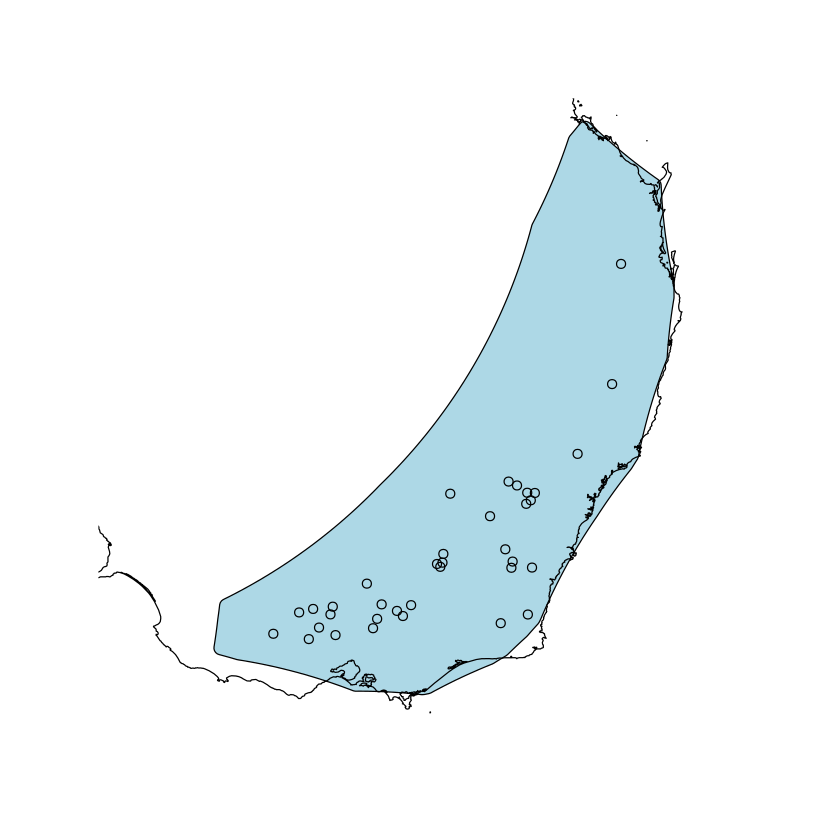

In [7]:
#read in extent and visualize
ext=readShapeSpatial(extentpoly)
OzCoast=shapefile("/home/megan/megan/research/gis_data/oz_coast/aus5m_coast_no_norfolk.shp")
plot(ext,col="lightblue")
points(units$Longitude, units$Latitude)
plot(OzCoast, add=T)

In [8]:
#read in environmental data

#read in bioclim data
clim_vars1=getData('worldclim', var='bio', res=0.5, path="/home/megan/megan/research/gis_data", 
                   lon=units[1,]$Longitude, lat=units[1,]$Latitude)
clim_vars2=getData('worldclim', var='bio', res=0.5, path="/home/megan/megan/research/gis_data", 
                   lon=units[1,]$Longitude+30, lat=units[1,]$Latitude)
clim_vars3=getData('worldclim', var='bio', res=0.5, path="/home/megan/megan/research/gis_data", 
                   lon=units[1,]$Longitude, lat=units[1,]$Latitude+30)
clim_vars4=getData('worldclim', var='bio', res=0.5, path="/home/megan/megan/research/gis_data", 
                   lon=units[1,]$Longitude+30, lat=units[1,]$Latitude+30)
clim_vars=merge(clim_vars1,clim_vars2,clim_vars3,clim_vars4)
#clim_vars = getData('worldclim', var='bio', res=2.5, path="/home/megan/megan/research/gis_data")    
#useful bioclim names
#bioclimnames=c("Annual Mean Temperature","Mean Diurnal Range","Isothermality","Temperature Seasonality",
  #     "Max Temperature of Warmest Month","Min Temperature of Coldest Month",
   #    "Temperature Annual Range","Mean Temperature of Wettest Quarter","Mean Temperature of Driest Quarter",
    #   "Mean Temperature of Warmest Quarter","Mean Temperature of Coldest Quarter","Annual Precipitation",
     #  "Precipitation of Wettest Month","Precipitation of Driest Month","Precipitation Seasonality",
      # "Precipitation of Wettest Quarter","Precipitation of Driest Quarter",
       #"Precipitation of Warmest Quarter","Precipitation of Coldest Quarter",
       #"Koppen Class","Temperature/Humidity Zone", "Altitude")

#read in altitude data
#alt=getData('alt', download=T, country='AUS') 
    #altitude (elevation); the data were aggregated from SRTM 90 m resolution data between -60 and 60 latitude
alt=getData('alt', country='AUS', path="/home/megan/megan/research/gis_data/oz_alt")

#read in soil data
awc005=raster("/home/megan/megan/research/gis_data/oz_soil/AWC_000_005_EV_N_P_AU_NAT_C_20140801.tif")
awc200=raster("/home/megan/megan/research/gis_data/oz_soil/AWC_100_200_EV_N_P_AU_NAT_C_20140801.tif")
nto005=raster("/home/megan/megan/research/gis_data/oz_soil/NTO_000_005_EV_N_P_AU_NAT_C_20140801.tif")
nto200=raster("/home/megan/megan/research/gis_data/oz_soil/NTO_100_200_EV_N_P_AU_NAT_C_20140801.tif")
pto005=raster("/home/megan/megan/research/gis_data/oz_soil/PTO_000_005_EV_N_P_AU_NAT_C_20140801.tif")
pto200=raster("/home/megan/megan/research/gis_data/oz_soil/PTO_100_200_EV_N_P_AU_NAT_C_20140801.tif")

#read in landscape data
presc=raster("/home/megan/megan/research/gis_data/oz_landscape/PrescottIndex_01_3s_lzw.tif")
mrvbf=raster("/home/megan/megan/research/gis_data/oz_landscape/mrvbf_3s.tif")

#read in koppen data
#koppen_raw=read.asciigrid("/home/megan/megan/research/gis_data/oz_koppen_classes/kpnall.txt")
#koppen_rb=as(koppen_raw, 'RasterBrick')
#names(koppen_rb)="koppen"  #rename

#read in temp/humidity zone data
#tmphu_raw=read.asciigrid("/home/megan/megan/research/gis_data/oz_tmphumid_zones/clim-zones.txt")
#tmphu_rb=as(tmphu_raw, 'RasterBrick')
#names(tmphu_rb)="tmphu"  #rename

In [9]:
#create environmental raster stack, cut to defined extent

#crop bioclim vars using polygon for extent
envvars=mask(crop(clim_vars,ext), ext)
rm(clim_vars)

#resample other layers to make same extent and add to raster stack
layers=c("alt","awc005","awc200","nto005","nto200","pto005","pto200","presc","mrvbf")  #list of layers
    #      20    21        22       23      24        25       26      27      28
for (i in 1:length(layers))
    {
      print(layers[i])
      resamp=resample(get(layers[[i]]), envvars,"bilinear")  #resample 
      resamp_ext=mask(resamp, ext)                           #mask regions outside distribution
      envvars=stack(envvars,resamp_ext)                      #add to stack
    }

#lazy box way
#range=extent(min(units$Longitude)-1,max(units$Longitude)+1,min(units$Latitude)-1,max(units$Latitude)+1)
#clim_vars_range=crop(clim_vars, range)

rm(alt,awc005,awc200,nto005,nto200,pto005,pto200,presc,mrvbf)

[1] "alt"
[1] "awc005"
[1] "awc200"
[1] "nto005"
[1] "nto200"
[1] "pto005"
[1] "pto200"
[1] "presc"
[1] "mrvbf"


In [ ]:
##convert site locations to UTM, so values will be in meters, not degrees
#no skip this and just convert from degrees to km when mapping (1degree=111km in SE Oz)
##get long/lat df
#LongLat=units[,19:20]
## Convert it to a sp object
#coordinates(LongLat)= ~ Longitude + Latitude # longitude first
## Add a coordinate reference system
#proj4string(LongLat) <- CRS("+proj=longlat +ellps=WGS84 +datum=WGS84")
## Project to UTM using spTransform
#LongLatUTM=spTransform(LongLat, CRS("+proj=utm +zone=55 ellps=WGS84"))
##add to dataframe
#units$LongitudeUTM=LongLatUTM@coords[,1]
#units$LatitudeUTM=LongLatUTM@coords[,2]

In [10]:
#extract values at sampling locations
units=cbind(units, extract(envvars, cbind(units$Longitude, units$Latitude)))

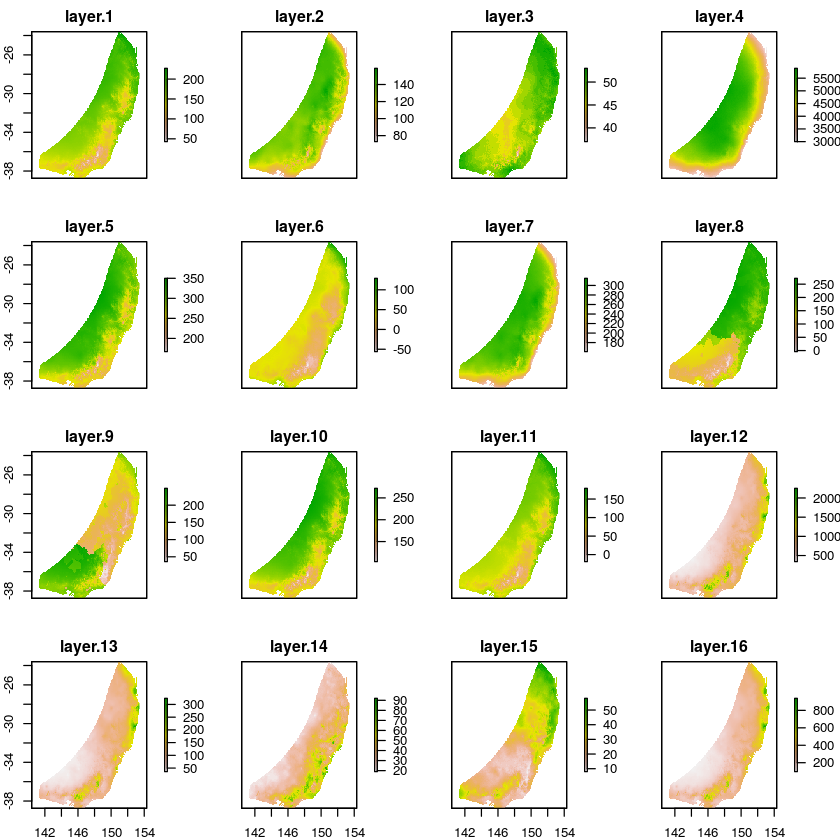

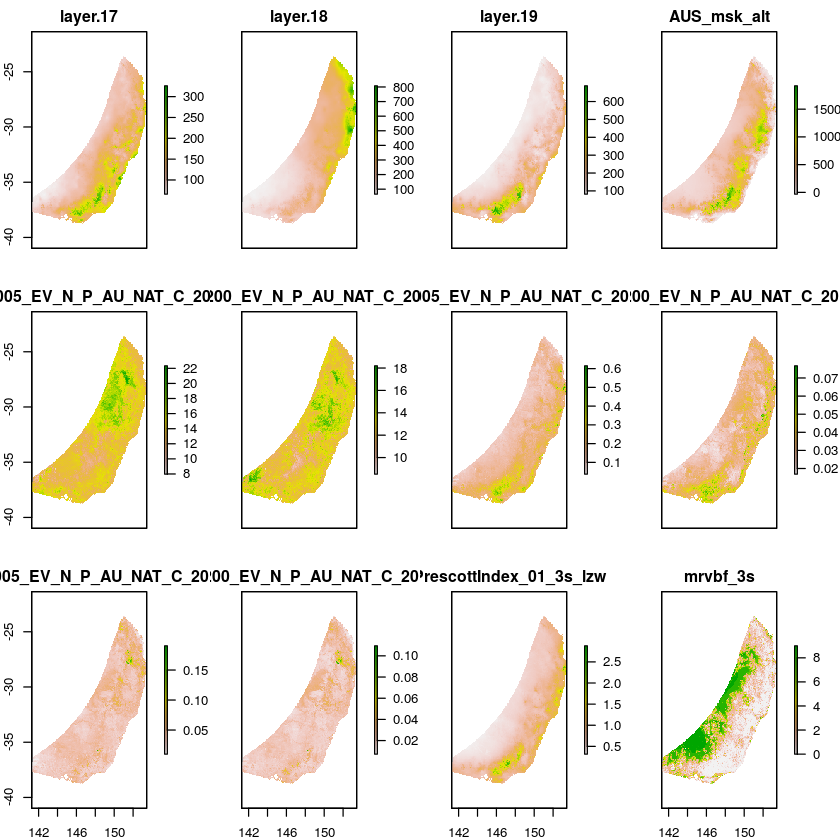

In [11]:
#visualize rasters, look for oddities
#pdf("envvars.pdf")
plot(envvars[[1:16]])
plot(envvars[[17:28]])
#dev.off()

In [12]:
#prep gdm

#gdm with fst as genetic distance matrix
site=as.integer(names)

#format population info
start=23
popenv=cbind(site,units[,c(19:20,start:ncol(units))])

#format and scale fst matrix
#shift to get rid of negative values
shift=min(distm)
dist.tx=distm-shift
#divide by max to scale 0-1
scale=max(dist.tx)
dist.tx=dist.tx/scale
print(min(dist.tx))
print(max(dist.tx))
#rescale distances
#unscaleddist=(scaleddist*scale)+shift

#format for gdm input
dist.m=as.matrix(dist.tx)
gdmDissim=data.frame(site,dist.m)
gdmTab.dis=formatsitepair(gdmDissim, bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                             predData=popenv, siteColumn="site")

[1] 0
[1] 1


In [ ]:
#run gdm on each environmental variable alone
expl=vector(mode = "integer", length = ncol(popenv)-3)
for (i in 4:ncol(popenv))
    {
        gdmTab.dis.test=formatsitepair(gdmDissim, bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                             predData=popenv[c(1:3,i)], siteColumn="site")
        #print(colnames(popenv)[i])
        gdm.test=gdm(gdmTab.dis.test, geo=F)
        #print(gdm.test$explained)
        expl[i-3]=gdm.test$explained
    }

In [ ]:
#correlation between enviro variables at sites
correlation=matrix(nrow=(ncol(units)-start+1), ncol=(ncol(units)-start+1))
rownames(correlation)=colnames(units[start:ncol(units)])
colnames(correlation)=colnames(units[start:ncol(units)])
for (i in start:(ncol(units)-1))
    {
        for (j in (i+1):ncol(units))
            {
               correlation[i-start+1,j-start+1]=cor(units[,i], units[,j], method="pearson")
            }
    }
correlation=cbind(expl,correlation)
#correlation
write.csv(correlation, file="env_expl_corr.csv", row.names=T, quote=F)
#examine to determine which variables to remove based on minimal impact and highly correlated

In [ ]:
#select variables to keep and increase permutations
#test sig of model and variables

#reduce the set of variables based on above
keep=c(3,8,11,16,21,24,26)+3
#list variables kept
names(popenv[keep])

gdmTab.dis.perm=formatsitepair(gdmDissim, bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                             predData=popenv[c(1:3,keep)], siteColumn="site")

#run perms
gdm.perm<- gdm.varImp(gdmTab.dis.perm, 
                          geo=TRUE, 
                          fullModelOnly = FALSE, 
                          nPerm = 1000,
                          parallel = TRUE)
gdm.perm
#1 summary each fitted model
#2 variable importance. 
    #Variable importance is measured as the amount full model deviance is reduced when that variable is removed
#3 significance. Significance is estimated using the bootstrapped p-value.

In [ ]:
#select variables to keep and increase permutations
#test sig of model and variables

#reduce the set of variables based on above
keep=c(3,11,16,24)
#list variables kept
names(popenv[keep+3])

gdmTab.dis.perm=formatsitepair(gdmDissim, bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                             predData=popenv[c(1:3,keep+3)], siteColumn="site")

#run perms
gdm.perm<- gdm.varImp(gdmTab.dis.perm, 
                          geo=TRUE, 
                          fullModelOnly = TRUE, 
                          nPerm = 1000,
                          parallel = TRUE)
gdm.perm
#1 summary each fitted model
#2 variable importance. 
    #Variable importance is measured as the amount full model deviance is reduced when that variable is removed
#3 significance. Significance is estimated using the bootstrapped p-value.


[1] 
[1] 
[1] GDM Modelling Summary
[1] Creation Date:  Tue Jul 25 11:46:03 2017
[1] 
[1] Name:  gdm.1
[1] 
[1] Data:  gdmTab.dis
[1] 
[1] Samples:  630
[1] 
[1] Geographical distance used in model fitting?  TRUE
[1] 
[1] NULL Deviance:  77.7143824604189
[1] GDM Deviance:  46.5875567666891
[1] Deviance Explained:  40.0528508472458
[1] 
[1] Intercept:  0.257928245108905
[1] 
[1] Predictor 1: Geographic
[1] Splines: 3
[1] Min Knot: 0.115077718164735
[1] 50% Knot: 3.33418148416332
[1] Max Knot: 13.417692334952
[1] Coefficient[1]: 0
[1] Coefficient[2]: 0
[1] Coefficient[3]: 0.443324281627271
[1] 
[1] Predictor 2: layer.3
[1] Splines: 3
[1] Min Knot: 44
[1] 50% Knot: 46.5
[1] Max Knot: 51
[1] Coefficient[1]: 0
[1] Coefficient[2]: 0.0535720787327039
[1] Coefficient[3]: 0.20105573154632
[1] 
[1] Predictor 3: layer.11
[1] Splines: 3
[1] Min Knot: 49
[1] 50% Knot: 79.5
[1] Max Knot: 108
[1] Coefficient[1]: 0.15658583512851
[1] Coefficient[2]: 0
[1] Coefficient[3]: 0.188427899111127
[1] 
[1] Pre

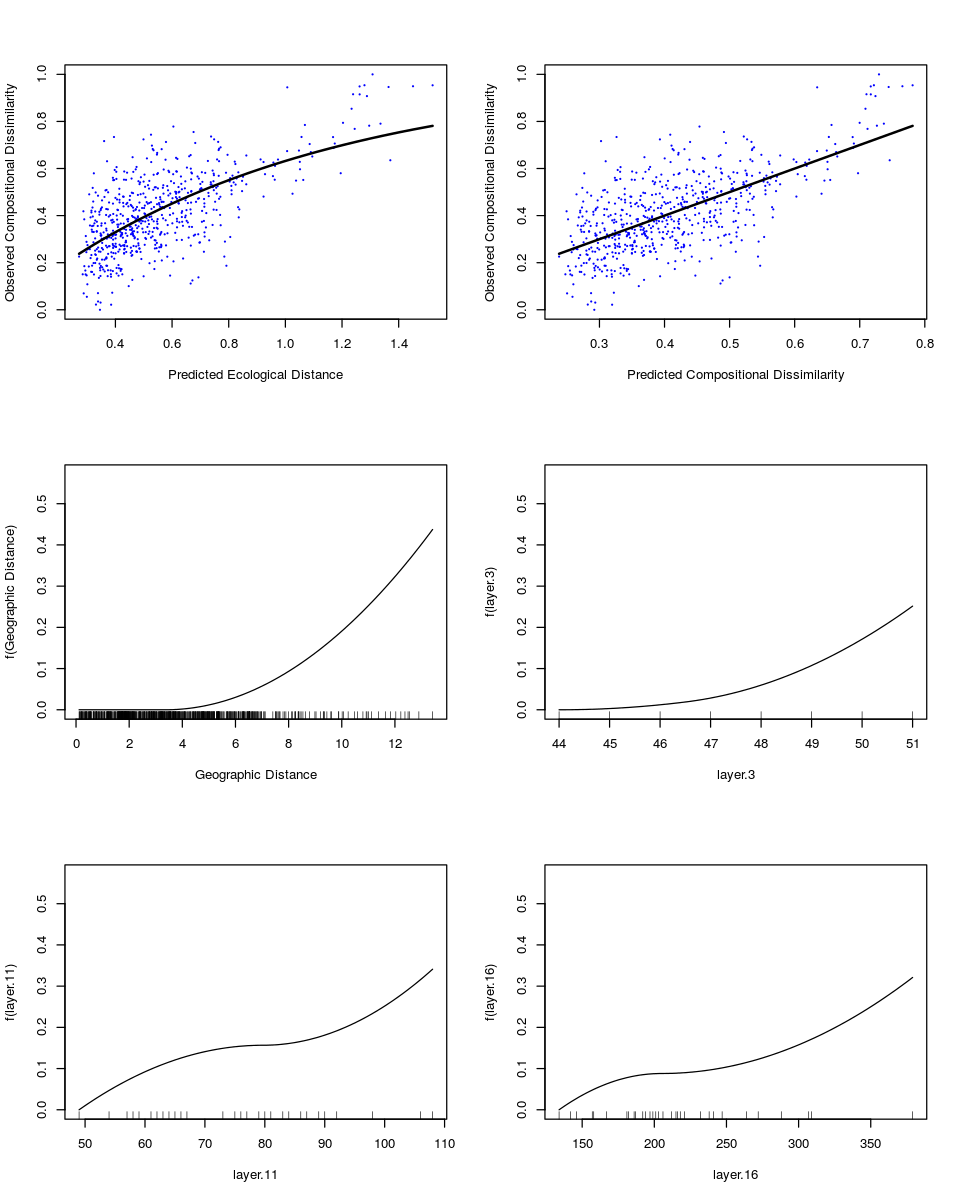

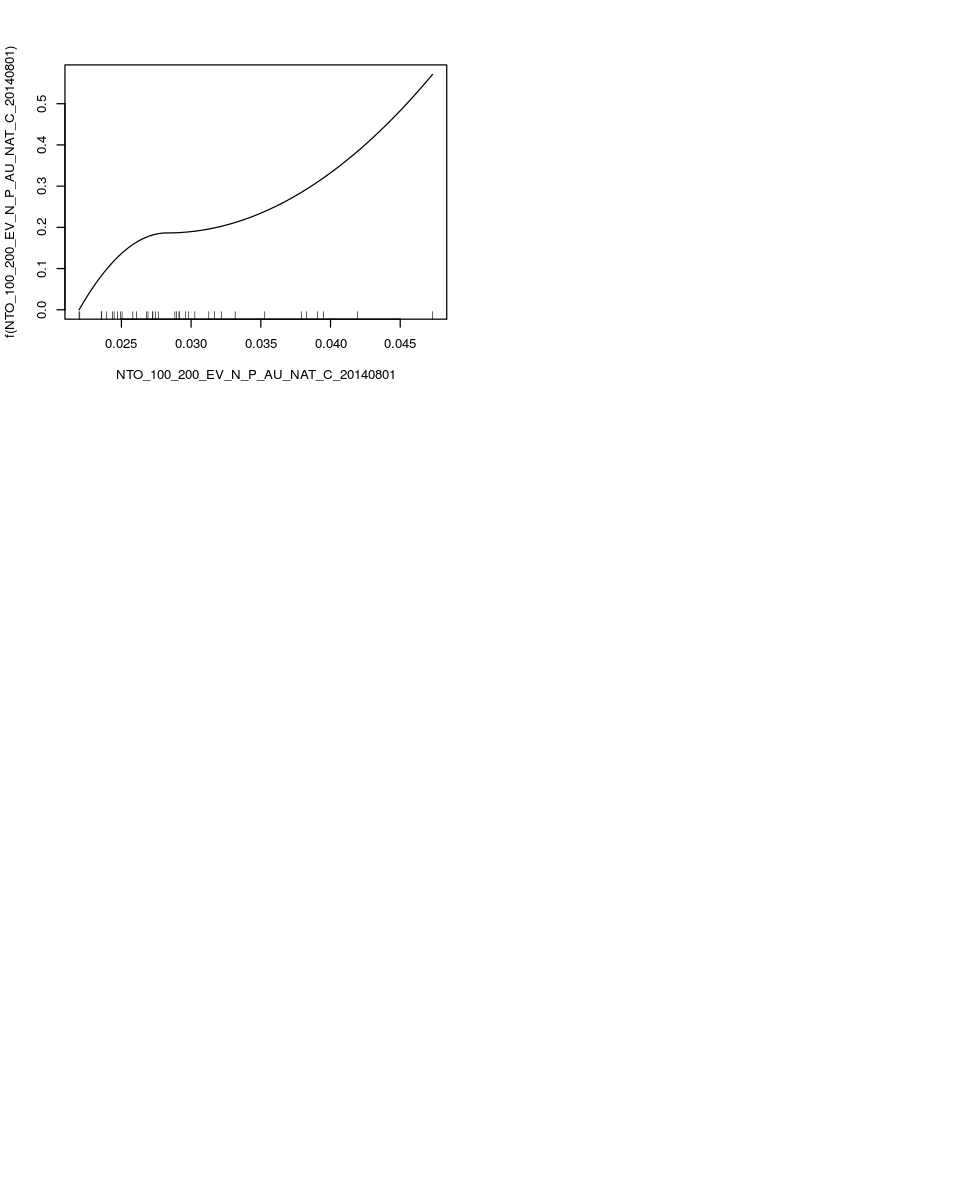

In [13]:
#run final GDM
options(repr.plot.width=8, repr.plot.height=10)
#select variables to keep
keep=c(3,11,16,24)
#reduce the set of variables based on above
gdmTab.dis=formatsitepair(gdmDissim, bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                             predData=popenv[c(1:3,keep+3)], siteColumn="site")
gdm.1=gdm(gdmTab.dis, geo=T)
print(summary(gdm.1))
#pdf("gdm_figs.pdf")
plot(gdm.1, plot.layout=c(3,2),
    include.rug=TRUE, 
    rug.sitepair=gdmTab.dis)
#dev.off()

In [14]:
#geography (scaled from 1degree=111km)
pdf("gdm_geog.pdf", height=4, width=6)
par(mfrow=c(1,1), mar=c(4,4,2,2))

gdm.1.splineDat <- isplineExtract(gdm.1)
plot(gdm.1.splineDat$x[,"Geographic"]*111, ((gdm.1.splineDat$y[,"Geographic"]*scale)+shift), lwd=1, ylim=c(-.007,0.04),
   type="l", xlab="geographic distance (km)", ylab="genomic distance")
dev.off()

pdf 
  2

In [17]:
# make figures and resample for geography
pdf("gdm_out.pdf")
par(mfrow=c(4,2), mar=c(5,4,2,2))
ymin=-0.007 #orig 0
ymax=0.06   #orig 0.6?

#enviro vs genetic dist
plot(gdm.1$ecological,gdm.1$observed, col="grey40",pch=20, cex=.5,
        xlab="environmental distance", ylab="genomic distance")
lines(sort(gdm.1$ecological),sort(gdm.1$predicted))
mtext("A",side=3, line=0, outer=F, cex=1.2)

#obsv vs predicted
plot(gdm.1$predicted, gdm.1$observed, col="grey40",pch=20, cex=.5,
        xlab="predicted genomic distance", ylab="observed genomic distance")
lines(c(0,1),c(0,1))
mtext("B",side=3, line=0, outer=F, cex=1.2)

#env vars
#nto
plot(gdm.1.splineDat$x[,"NTO_100_200_EV_N_P_AU_NAT_C_20140801"], 
     ((gdm.1.splineDat$y[,"NTO_100_200_EV_N_P_AU_NAT_C_20140801"]*scale)+shift), lwd=1, ylim=c(ymin,ymax),
   type="l", xlab="total nitrogen (%)", ylab="genomic distance")
mtext("C",side=3, line=0, outer=F, cex=1.2)
#bio11 (scaled back to degrees c)
plot(gdm.1.splineDat$x[,"layer.11"]/10, ((gdm.1.splineDat$y[,"layer.11"]*scale)+shift), lwd=1, ylim=c(ymin,ymax),
   type="l", xlab="mean temperature of coldest quarter (°C)", ylab="genomic distance")
mtext("D",side=3, line=0, outer=F, cex=1.2)
#bio16
plot(gdm.1.splineDat$x[,"layer.16"], ((gdm.1.splineDat$y[,"layer.16"]*scale)+shift), lwd=1, ylim=c(ymin,ymax),
   type="l", xlab="precipitation of wettest quarter (mm)", ylab="genomic distance")
mtext("E",side=3, line=0, outer=F, cex=1.2)
#bio3
plot(gdm.1.splineDat$x[,"layer.3"]/100, ((gdm.1.splineDat$y[,"layer.3"]*scale)+shift), lwd=1, ylim=c(ymin,ymax),
   type="l", xlab="isothermality", ylab="genomic distance")
mtext("F",side=3, line=0, outer=F, cex=1.2)


#geography (scaled from 1degree=111km)
plot(gdm.1.splineDat$x[,"Geographic"]*111, ((gdm.1.splineDat$y[,"Geographic"]*scale)+shift), lwd=1, ylim=c(ymin,ymax),
   type="l", xlab="geographic distance (km)", ylab="genomic distance")
mtext("G",side=3, line=0, outer=F, cex=1.2)

#gdm with x% of units (populations/samples) removed
testsize=.7 #percent of sites to keep for test
nperms=100
plot(gdm.1.splineDat$x[,"Geographic"]*111, ((gdm.1.splineDat$y[,"Geographic"]*scale)+shift), lwd=1, ylim=c(ymin,ymax),
   type="l", xlab="geographic distance (km)", ylab="genomic distance")
mtext("H",side=3, line=0, outer=F, cex=1.2)

#format and scale fst matrix
shift=min(distm)               #shift to get rid of negative values
dist.tx=distm-shift
scale=max(dist.tx)             #divide by max to scale 0-1
dist.tx=dist.tx/scale
dist.m=as.matrix(dist.tx)

for (i in 1:nperms)
    {
      #identify and remove samples
      keeppop=sample(names,dim(units)[1]*testsize,replace=F)
      #remove from site list
      keepnames=match(names,keeppop)
      site_sub=as.integer(names[!is.na(keepnames)])
      #remove from enviro vars
      popenv_sub=cbind(site_sub,popenv[site_sub,c(2:3,keep+3)])  #just 19 bioclim vars
      #remove from dist matrix
      keepdist=match(labels(distm),keeppop)
      dist_sub=dist.m[!is.na(keepdist),!is.na(keepdist)]

      #format for gdm input
      gdmDissimPerm=data.frame(site_sub,dist_sub)
      gdmTab.dis.perm=formatsitepair(gdmDissimPerm, bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                                     predData=popenv_sub, siteColumn="site_sub")

      #run GDM
      gdm.perm=gdm(gdmTab.dis.perm, geo=T)

      #plot geography
      gdm.perm.splineDat <- isplineExtract(gdm.perm)
      points(gdm.perm.splineDat$x[,"Geographic"]*111, ((gdm.perm.splineDat$y[,"Geographic"]*scale)+shift),type="l")   
    }

points(gdm.1.splineDat$x[,"Geographic"]*111, ((gdm.1.splineDat$y[,"Geographic"]*scale)+shift), 
       lwd=2, ylim=c(ymin,ymax),
   type="l", xlab="geographic distance (km)", ylab="genomic distance ()",col="grey", lty=2)

dev.off()

pdf 
  2

In [ ]:
#validate the model (code modified from CBA KM section 2.6)
nperm=1000                                                   #number of permutations to run
train=0.7                                                 #proportion of sites to use as training

# set up the cross-validation
nsites=nrow(units)                                        #total number of sites
ntrain=floor(nsites*train)                                #number of training sites
ntest=nsites-ntrain                                       #number of test sites
site.sampler=c(rep(1,times=ntrain),rep(0,times=ntest))   #0/1 vector for train/test
correlation=rep(0,length=nperm)                           #0 vector for correlations

#run permutations
for(i in 1:nperm)
    {
      site.sampler<-site.sampler[sample(length(site.sampler))]            #randomly assign site to train/test
    
      #set up training data
      names.train=names[which(site.sampler==1)]                           #train names
      dist.train=as.matrix(distm)[which(site.sampler==1),which(site.sampler==1)]    #subset distance matrix
          #format and scale fst matrix
          shift=min(dist.train)        #shift to get rid of negative values
          dist.tx=dist.train-shift
          scale=max(dist.tx)           #divide by max to scale 0-1
          dist.tx=dist.tx/scale
          dist.train.m=as.matrix(dist.tx)    #format for gdm input  
      site.train=site[which(site.sampler==1)]                             #subset site list
      popenv.train=popenv[which(site.sampler==1),]                        #subset prediction data
      gdmDissim.train=data.frame(site.train,dist.train.m)                   #create site/dist dataframe
      colnames(gdmDissim.train)=c("site", as.character(names.train))      #rename columns in dataframe               
      gdmTab.train=formatsitepair(gdmDissim.train ,bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                                  predData=popenv.train[c(1:3,keep+3)], siteColumn="site")
    
      #get test data
      names.test=names[which(site.sampler==0)]                           #test names
      dist.test=as.matrix(distm)[which(site.sampler==0),which(site.sampler==0)]    #subset distance matrix
          #format and scale fst matrix
          shift=min(dist.test)        #shift to get rid of negative values
          dist.tx=dist.test-shift
          scale=max(dist.tx)           #divide by max to scale 0-1
          dist.tx=dist.tx/scale
          dist.test.m=as.matrix(dist.tx)    #format for gdm input      
      site.test=site[which(site.sampler==0)]                             #subset site list
      popenv.test=popenv[which(site.sampler==0),]                        #subset prediction data
      gdmDissim.test=data.frame(site.test,dist.test.m)                     #create site/dist dataframe
      colnames(gdmDissim.test)=c("site", as.character(names.test))      #rename columns in dataframe               
      gdmTab.test=formatsitepair(gdmDissim.test ,bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                                  predData=popenv.test[c(1:3,keep+3)], siteColumn="site")   
    
      #fit model on training data
      train.mod=gdm(gdmTab.test, geo=T)
      #predict on test data
      pred.test=predict(train.mod,gdmTab.test)
      #calculate correlation between observed and predicted dissimilarities
      correlation[i]=cor(pred.test, gdmTab.test[,1], method="pearson")
    }

hist(correlation)
abline(v=mean(correlation))
mean(correlation)
median(correlation)
sd(correlation)

In [ ]:
#prediction in space
options(repr.plot.width=4, repr.plot.height=6)

# transform climate rasters & plot pattern
rastTrans <- gdm.transform(gdm.1, envvars[[keep]])
#plot(rastTrans)

rastDat <- na.omit(getValues(rastTrans))
#rastDat <- sampleRandom(rastTrans, 50000) # can use if rasters are large
pcaSamp <- prcomp(rastDat)
# note the use of the 'index' argument
pcaRast <- predict(rastTrans, pcaSamp, index=1:3)
# scale rasters
pcaRast[[1]] <- (pcaRast[[1]]-pcaRast[[1]]@data@min) /
(pcaRast[[1]]@data@max-pcaRast[[1]]@data@min)*255
pcaRast[[2]] <- (pcaRast[[2]]-pcaRast[[2]]@data@min) /
(pcaRast[[2]]@data@max-pcaRast[[2]]@data@min)*255
pcaRast[[3]] <- (pcaRast[[3]]-pcaRast[[3]]@data@min) /
(pcaRast[[3]]@data@max-pcaRast[[3]]@data@min)*255

#pdf("emellb_gdm_space_3111624_321.pdf", height=12, width=8.6)
plotRGB(pcaRast, r=3, g=2, b=1)
text(units$Longitude,units$Latitude, 
     label=substring(units$PopulationName, 4), cex = .6)#, col=samples$cov_color) #add names and colors
plot(OzCoast,add=T)
#dev.off()

#get loadings
round((sweep(pcaSamp$rotation, 2, colSums(abs(pcaSamp$rotation)), "/")*100),digits=0)[,1:3]

In [ ]:
## read in future climate rasters
#2070
future2070=stack()

#read in future layers for bioclim variables kept
keepbc=c(3,11,16)
for (i in 1:length(keepbc))
    {
        temp_tif=raster(paste("/home/megan/megan/research/gis_data/mc85bi70_05res/mc85bi70",keepbc[i],".tif",sep=""))
        temp_rb=as(temp_tif, 'RasterBrick')
        #resample to make same extent as distribution
        temp_crop=mask(crop(temp_rb,ext), ext)
        names(temp_crop)=paste("layer.",keepbc[i],sep="")
        #stack bricks
        future2070=stack(future2070,temp_crop)       
    }

#add current soil/landscape layers to stack
keepsl=c(24)
for (j in 1:length(keepsl))
    {
        future2070=stack(future2070,envvars[[keepsl[j]]])
    }

In [ ]:
#prediction in future space
options(repr.plot.width=4, repr.plot.height=6)

# transform climate rasters & plot pattern
rastTrans2070 <- gdm.transform(gdm.1, future2070)
#plot(rastTrans)

rastDat2070 <- na.omit(getValues(rastTrans2070))
#rastDat <- sampleRandom(rastTrans, 50000) # can use if rasters are large
pcaSamp2070 <- prcomp(rastDat2070)
# note the use of the 'index' argument
pcaRast2070 <- predict(rastTrans2070, pcaSamp2070, index=1:3)
# scale rasters
pcaRast2070[[1]] <- (pcaRast2070[[1]]-pcaRast2070[[1]]@data@min) /
(pcaRast2070[[1]]@data@max-pcaRast2070[[1]]@data@min)*255
pcaRast2070[[2]] <- (pcaRast2070[[2]]-pcaRast2070[[2]]@data@min) /
(pcaRast2070[[2]]@data@max-pcaRast2070[[2]]@data@min)*255
pcaRast2070[[3]] <- (pcaRast2070[[3]]-pcaRast2070[[3]]@data@min) /
(pcaRast2070[[3]]@data@max-pcaRast2070[[3]]@data@min)*255

#pdf("emellb_gdm_2070_3111624_321.pdf")
plotRGB(pcaRast2070, r=3, g=2, b=1)
text(samples$Longitude,samples$Latitude, 
     label=substring(samples$PopulationName, 4), cex = .6)#, col=samples$cov_color) #add names and colors
plot(OzCoast,add=T)
#dev.off()

#get loadings
round((sweep(pcaSamp$rotation, 2, colSums(abs(pcaSamp$rotation)), "/")*100),digits=0)[,1:3]

In [ ]:
#jupyter mucks up the figure, okay as pdf
## predict difference in time ##
#2070
options(repr.plot.width=4, repr.plot.height=6)
#pdf("emellb_gdm_2070_diff.pdf")
timePred <- predict(gdm.1, envvars[[keep]], time=T, predRasts=future2070)
#hist(timePred$values)
timePred[timePred>1]=NA
plot(timePred)
text(samples$Longitude,samples$Latitude, 
     label=substring(samples$PopulationName, 4), cex = .6)#, col=samples$cov_color) #add names and colors
#plot(OzCoast,add=T)
#dev.off()

In [ ]:
#make nice figure
pdf("emellb_gdm_space_time.pdf", height=12, width=17)
par(mfrow=c(1,2), mar=c(0,0,0,0))

#plot current 
plotRGB(pcaRast, r=3, g=2, b=1)
text(145.8,-24.35, label="(A) Predicted\nGenomic Composition\nAcross Space", cex=2)
text(units$Longitude,units$Latitude, 
     label=substring(units$PopulationName, 4), cex=1)#, col=samples$cov_color) #add names and colors
plot(OzCoast,add=T)

#plot future difference
plot(timePred, axes=F, bty="n", box=F, legend=F)
text(145.9,-24.2, label="(B) Predicted Change in\nGenomic Composition\nOver Time", cex=2)
text(samples$Longitude,samples$Latitude, 
     label=substring(samples$PopulationName, 4), cex=1)#, col=samples$cov_color) #add names and colors
plot(timePred, legend.only=T,smallplot=c(.36, .4, .49, .89))
#      legend.args=list(text='Predicted Genetic Change Over Time', side=3, line=2.5, cex=2))
plot(OzCoast,add=T)

dev.off()

In [ ]:
# map similarity to focal cell (code modified from CBA KM section 3.4)
# simulated reforestation site:  match future conditions at site to current conditions at potential sources
#juptyer mucks up the figure, okay in pdf

#define locations of interest
focal1=c(148,-35)
focal2=c(150,-30)
foci=rbind(focal1,focal2)

#extract enviro data for reforestation locations from transformed current data
#foci_env_now=extract(rastTrans,foci)
foci_env_future=extract(rastTrans2070, foci)

##make future raster into matrix
#trans.env.future=as.matrix(rastTrans2070)
#col.longs=xFromCol(rastTrans2070)
#row.lats=yFromRow(rastTrans2070)
#Cell_Long=rep(col.longs, times=nrow(rastTrans2070))
#Cell_Lat=rep(row.lats, each=ncol(rastTrans2070), times=1)
#trans.env.future<-cbind(Cell_Long, Cell_Lat, trans.env.future)
#trans.env.future <- trans.env.future[complete.cases(trans.env.future),]

#make current raster into matrix
trans.env.current=as.matrix(rastTrans)
col.longs=xFromCol(rastTrans)
row.lats=yFromRow(rastTrans)
Cell_Long=rep(col.longs, times=nrow(rastTrans))
Cell_Lat=rep(row.lats, each=ncol(rastTrans), times=1)
trans.env.current<-cbind(Cell_Long, Cell_Lat, trans.env.current)
trans.env.current<-trans.env.current[complete.cases(trans.env.current),]

#calculate similarity to current transformed data
sim.focal1=rep(0, length=nrow(trans.env.current))  #initialize vectors
sim.focal2=rep(0, length=nrow(trans.env.current))
for(i in 1:nrow(trans.env.current))                #loop over cells
    {
        envdist1=sum(abs(trans.env.current[i,c(3:ncol(trans.env.current))] - foci_env_future[1,]))
        sim.focal1[i] <- exp(-1 * (gdm.1$intercept + envdist1))
        envdist2=sum(abs(trans.env.current[i,c(3:ncol(trans.env.current))] - foci_env_future[2,]))
        sim.focal2[i] <- exp(-1 * (gdm.1$intercept + envdist2))
    }

#format to raster and plot
pdf("emellb_reforest.pdf", height=12, width=17)
par(mfrow=c(1,2), mar=c(0,0,0,0))

#focal1.ras=raster(rastTrans2070,layer=1)
focal1.ras=raster(rastTrans,layer=1)
#focal1.ras=rasterize(trans.env.future[,c(1:2)], focal1.ras, field=sim.focal1)
focal1.ras=rasterize(trans.env.current[,c(1:2)], focal1.ras, field=sim.focal1)
plot(focal1.ras, axes=F, bty="n", box=F, legend=F)
points(x=foci[1,1], y=foci[1,2], cex=3, pch="o")

#format to raster and plot
#focal2.ras=raster(rastTrans2070,layer=1)
focal2.ras=raster(rastTrans,layer=1)
#focal2.ras=rasterize(trans.env.future[,c(1:2)], focal1.ras, field=sim.focal2)
focal2.ras=rasterize(trans.env.current[,c(1:2)], focal1.ras, field=sim.focal2)
plot(focal2.ras, axes=F, bty="n", box=F, legend=F)
points(x=foci[2,1], y=foci[2,2], cex=3, pch="o")
plot(timePred, legend.only=T,smallplot=c(0.25, .28, .52, .92))

text(144.8,-24, label="Strength of Match to\nHypothetical Reforestation Sites", cex=2)

dev.off()

###############################

In [ ]:
##gdm with individual genetic distance matrix
site=as.integer(samples.noclones$SampleName)

#format population info
sampleenv=cbind(site,samples.noclones[,c(19:20,26:ncol(populations))])

#format and scale distance matrix
#shift to get rid of negative values
shift=min(genos.dist.noclones)
genos.dist.tx=genos.dist.noclones-shift
#divide by max to scale 0-1
scale=max(genos.dist.tx)
genos.dist.tx=genos.dist.tx/scale
print(min(genos.dist.tx))
print(max(genos.dist.tx))
#rescale distances
#unscaleddist=(scaleddist*scale)+shift
genos.dist.m=as.matrix(genos.dist.tx)
gdmDissim=data.frame(site,genos.dist.m)
gdmTab.dis=formatsitepair(gdmDissim, bioFormat=3, XColumn="Longitude", YColumn="Latitude",
                             predData=sampleenv, siteColumn="site")
#run GDM
gdm.1=gdm(gdmTab.dis, geo=T)
#summary(gdm.1)
#str(gdm.1)
plot(gdm.1, plot.layout=c(2,2))
gdm.1.splineDat <- isplineExtract(gdm.1)
#str(gdm.1.splineDat)
plot(gdm.1.splineDat$x[,"Geographic"], gdm.1.splineDat$y[,"Geographic"], lwd=3,
     type="l", xlab="Geographic distance", ylab="Partial ecological distance")

gdm.1.pred <- predict(gdm.1, gdmTab.dis)
plot(gdmTab.dis$distance, gdm.1.pred, xlab="Observed dissimilarity",
     ylab="Predicted dissimilarity", xlim=c(0,1), ylim=c(0,1), pch=20, col=rgb(0,0,1,0.5))
lines(c(-1,2), c(-1,2))

In [ ]:
## GDM with allele abundance by population ##

#read in allele abundance data (sites x allele)
sitealleles=read.delim(paste(infilepath,siteallelematrix,sep=""), sep=",", header=F)     #read in file
colnames(sitealleles)[1]="PopulationName"
colnames(sitealleles)[2]="Longitude"
colnames(sitealleles)[3]="Latitude"
#sitealleles[1:5,1:10]

#enviro data
siteenviro=populations[,c(19:21,26:ncol(populations))]

#format data
gdmTab=formatsitepair(sitealleles, bioFormat=1, XColumn="Longitude", YColumn="Latitude", siteColumn="PopulationName",
                     predData=siteenviro, abundance=T, weightType="richness")
#scale distance to 0-1
gdmTab$distance=gdmTab$distance-min(gdmTab$distance)
gdmTab$distance=gdmTab$distance/max(gdmTab$distance)

#run GDM
gdm.1=gdm(gdmTab, geo=T)
#summary(gdm.1)
#str(gdm.1)
length(gdm.1$predictors) # get idea of number of panels
plot(gdm.1, plot.layout=c(2,2))
gdm.1.splineDat <- isplineExtract(gdm.1)
#str(gdm.1.splineDat)
plot(gdm.1.splineDat$x[,"Geographic"], gdm.1.splineDat$y[,"Geographic"], lwd=3,
     type="l", xlab="Geographic distance", ylab="Partial ecological distance")

gdm.1.pred <- predict(gdm.1, gdmTab)
plot(gdmTab$distance, gdm.1.pred, xlab="Observed dissimilarity",
     ylab="Predicted dissimilarity", xlim=c(0,1), ylim=c(0,1), pch=20, col=rgb(0,0,1,0.5))
lines(c(-1,2), c(-1,2))